# Réseau de Neurones from scratch sur MNIST (sans Keras ni PyTorch)
Ce notebook implémente un réseau de neurones simple capable de classer les chiffres manuscrits (MNIST)
en utilisant uniquement NumPy. Aucune bibliothèque de machine learning n’est utilisée.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import os
from urllib.request import urlretrieve
import pickle

## Chargement du dataset MNIST depuis GitHub (.npz)

In [7]:
import urllib.request

def load_mnist_from_github(url="https://github.com/ElKarizmo/MNIST/raw/160d22422bd6a5c3a3e88818d3bd5e8fecbb6392/mnist.npz", filename="mnist.npz"):
    if not os.path.exists(filename):
        print("Téléchargement du fichier MNIST depuis GitHub...")
        urllib.request.urlretrieve(url, filename)

    with np.load(filename) as data:
        X_train = data['x_train'].reshape(-1, 28*28) / 255.0
        y_train = data['y_train']
        X_test = data['x_test'].reshape(-1, 28*28) / 255.0
        y_test = data['y_test']
    return X_train, y_train, X_test, y_test

In [8]:
X_train, y_train, X_test, y_test = load_mnist_from_github()

Téléchargement du fichier MNIST depuis GitHub...


## Classe du réseau de neurones

In [9]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.weights = []
        self.biases = []
        self.loss_history = []
        self.accuracy_history = []
        self.initialize_weights()

    def initialize_weights(self):
        for i in range(len(self.layers) - 1):
            w = np.random.randn(self.layers[i], self.layers[i+1]) * np.sqrt(1. / self.layers[i])
            b = np.zeros((1, self.layers[i+1]))
            self.weights.append(w)
            self.biases.append(b)

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return (z > 0).astype(float)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward_propagation(self, X):
        a = X
        activations = [a]
        zs = []
        for i in range(len(self.weights) - 1):
            z = a.dot(self.weights[i]) + self.biases[i]
            zs.append(z)
            a = self.relu(z)
            activations.append(a)
        z = a.dot(self.weights[-1]) + self.biases[-1]
        zs.append(z)
        a = self.softmax(z)
        activations.append(a)
        return activations, zs

    def back_propagation(self, activations, zs, X, y):
        m = X.shape[0]
        y_encoded = np.zeros((m, self.layers[-1]))
        y_encoded[np.arange(m), y] = 1

        delta = activations[-1] - y_encoded
        dW = [0] * len(self.weights)
        dB = [0] * len(self.biases)

        dW[-1] = activations[-2].T.dot(delta) / m
        dB[-1] = np.sum(delta, axis=0, keepdims=True) / m

        for l in range(len(self.layers) - 2, 0, -1):
            delta = delta.dot(self.weights[l].T) * self.relu_derivative(zs[l-1])
            dW[l-1] = activations[l-1].T.dot(delta) / m
            dB[l-1] = np.sum(delta, axis=0, keepdims=True) / m
        return dW, dB

    def update_weights(self, dW, dB, learning_rate):
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * dW[i]
            self.biases[i] -= learning_rate * dB[i]

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        y_encoded = np.zeros_like(y_pred)
        y_encoded[np.arange(m), y_true] = 1
        log_probs = -np.log(y_pred[range(m), y_true] + 1e-9)
        return np.sum(log_probs) / m

    def fit(self, X, y, learning_rate=0.1, n_iter=100):
        for i in range(n_iter):
            activations, zs = self.forward_propagation(X)
            loss = self.compute_loss(y, activations[-1])
            preds = np.argmax(activations[-1], axis=1)
            acc = np.mean(preds == y)
            self.loss_history.append(loss)
            self.accuracy_history.append(acc)
            dW, dB = self.back_propagation(activations, zs, X, y)
            self.update_weights(dW, dB, learning_rate)
            if i % 1 == 0:
                print(f"Iteration {i}: Loss={loss:.4f}, Accuracy={acc*100:.2f}%")

    def predict(self, X):
        activations, _ = self.forward_propagation(X)
        return np.argmax(activations[-1], axis=1)

In [17]:
model = NeuralNetwork(layers=[784, 256, 128,10])

model.fit(X_train, y_train, learning_rate=0.1, n_iter=100)
with open("/content/mnist_model_256g.pkl", "wb") as f:
    pickle.dump((model.weights, model.biases), f)

Iteration 0: Loss=2.3015, Accuracy=11.28%
Iteration 1: Loss=2.2787, Accuracy=13.34%
Iteration 2: Loss=2.2563, Accuracy=16.91%
Iteration 3: Loss=2.2339, Accuracy=22.09%
Iteration 4: Loss=2.2112, Accuracy=28.68%
Iteration 5: Loss=2.1877, Accuracy=35.02%
Iteration 6: Loss=2.1634, Accuracy=40.84%
Iteration 7: Loss=2.1378, Accuracy=46.11%
Iteration 8: Loss=2.1109, Accuracy=50.91%
Iteration 9: Loss=2.0824, Accuracy=54.77%
Iteration 10: Loss=2.0522, Accuracy=57.87%
Iteration 11: Loss=2.0201, Accuracy=60.26%
Iteration 12: Loss=1.9861, Accuracy=62.08%
Iteration 13: Loss=1.9502, Accuracy=63.57%
Iteration 14: Loss=1.9125, Accuracy=64.89%
Iteration 15: Loss=1.8729, Accuracy=65.93%
Iteration 16: Loss=1.8317, Accuracy=66.81%
Iteration 17: Loss=1.7890, Accuracy=67.65%
Iteration 18: Loss=1.7450, Accuracy=68.45%
Iteration 19: Loss=1.6997, Accuracy=69.21%
Iteration 20: Loss=1.6535, Accuracy=69.92%
Iteration 21: Loss=1.6066, Accuracy=70.51%
Iteration 22: Loss=1.5594, Accuracy=71.12%
Iteration 23: Loss=1.

In [23]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML


losses = model.loss_history
accuracies = model.accuracy_history
epochs = len(losses)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
line1, = ax1.plot([], [], 'r-', label='Perte')
line2, = ax2.plot([], [], 'g-', label='Précision')


ax1.set_xlim(0, epochs)
ax1.set_ylim(0, max(losses) + 0.1)
ax1.set_title("Animation de la Perte")
ax1.set_xlabel("Itérations")
ax1.set_ylabel("Perte")
ax1.legend()

ax2.set_xlim(0, epochs)
ax2.set_ylim(0, 1.0)
ax2.set_title("Animation de la Précision")
ax2.set_xlabel("Itérations")
ax2.set_ylabel("Précision")
ax2.legend()


def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return line1, line2

def animate(i):
    x = list(range(i + 1))
    line1.set_data(x, losses[:i + 1])
    line2.set_data(x, accuracies[:i + 1])
    return line1, line2

ani = animation.FuncAnimation(fig, animate, init_func=init,
                              frames=epochs, interval=100, blit=True)

plt.close(fig)
HTML(ani.to_jshtml())


Accuracy: 0.975


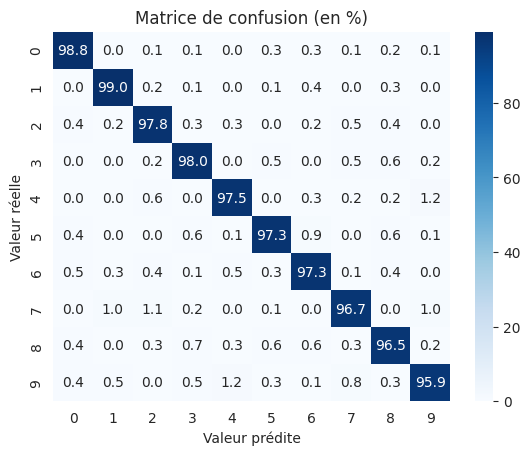

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.97      0.97       892
           6       0.97      0.97      0.97       958
           7       0.98      0.97      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [15]:
import seaborn as sns

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

sns.set_style("darkgrid")
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", cbar=True)

plt.xlabel("Valeur prédite")
plt.ylabel("Valeur réelle")
plt.title("Matrice de confusion (en %)")
plt.show()

print(classification_report(y_test, y_pred))


## Visualisation des courbes de perte et de précision

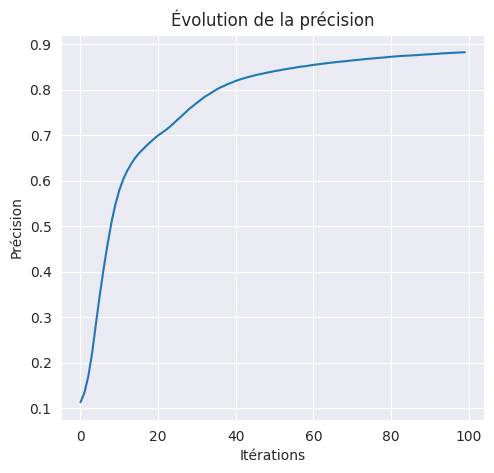

In [24]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(model.loss_history)
plt.title("Évolution de la perte")
plt.xlabel("Itérations")
plt.ylabel("Perte")

plt.subplot(1,2,2)
plt.plot(model.accuracy_history)
plt.title("Évolution de la précision")
plt.xlabel("Itérations")
plt.ylabel("Précision")
plt.show()

In [14]:
from IPython.display import display
from ipywidgets import FileUpload, Button, VBox, Output
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import io

uploader = FileUpload(accept='image/*', multiple=False)
predict_button = Button(description="Prédire le chiffre")
output = Output()

def predict_image(_):
    output.clear_output()
    if uploader.value:
        file_info = list(uploader.value.values())[0]
        img_data = file_info['content']
        image = Image.open(io.BytesIO(img_data)).convert("L").resize((28, 28))

        img_array = np.array(image)


        if img_array.mean() > 127:
            img_array = 255 - img_array

        img_array = img_array / 255.0
        img_input = img_array.reshape(1, 784)


        prediction = model.predict(img_input)
        predicted_label = prediction[0]

        with output:
            plt.imshow(img_array, cmap="gray")
            plt.title(f"Chiffre prédit : {predicted_label}")
            plt.axis("off")
            plt.show()
    else:
        with output:
            print("Veuillez uploader une image.")

predict_button.on_click(predict_image)

display(VBox([uploader, predict_button, output]))
